# vegas51s - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 15 # vegas51s
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6004, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6004 entries, 0 to 6003
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            6004 non-null   int64  
 1   dimCustomerMasterId     6004 non-null   int64  
 2   customerNumber          6004 non-null   object 
 3   year                    6004 non-null   int64  
 4   productGrouping         6004 non-null   object 
 5   totalSpent              6004 non-null   float64
 6   recentDate              6004 non-null   object 
 7   attendancePercent       6004 non-null   float64
 8   renewedBeforeDays       6004 non-null   int64  
 9   isBuyer                 6004 non-null   object 
 10  source_tenure           6004 non-null   int64  
 11  tenure                  6004 non-null   int64  
 12  distToVenue             6004 non-null   float64
 13  totalGames              6004 non-null   int64  
 14  recency                 6004 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
        "attendancePercent",
        "source_tenure",
        "tenure",
        "missed_games_1",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3612, 11)
Unseen Data For Predictions: (638, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "attendancePercent",
        "source_tenure",
        "tenure",
        "missed_games_1",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8287,0.9165,0.7551,0.7022,0.7269,0.6024,0.6040,0.3060
xgboost,Extreme Gradient Boosting,0.8274,0.9166,0.7443,0.7042,0.7231,0.5979,0.5990,0.3140


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8599,0.9396,0.7609,0.7692,0.7650,0.6653,0.6653
1,0.8176,0.9116,0.7391,0.6800,0.7083,0.5760,0.5770
2,0.8306,0.9230,0.7283,0.7128,0.7204,0.5990,0.5990
3,0.8436,0.9244,0.7849,0.7228,0.7526,0.6386,0.6397
4,0.8241,0.9202,0.6989,0.7143,0.7065,0.5810,0.5810
5,0.8176,0.9061,0.7312,0.6869,0.7083,0.5758,0.5764
6,0.8404,0.9226,0.7742,0.7200,0.7461,0.6299,0.6308
7,0.7948,0.8883,0.7419,0.6389,0.6866,0.5353,0.5386
8,0.8339,0.9156,0.8387,0.6842,0.7536,0.6303,0.6377
9,0.8241,0.9132,0.7527,0.6931,0.7216,0.5934,0.5945


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1754, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
4250,15,322940238,588545,2021,Mini Plan,325.44,2021-07-29,0.333333,94,TRUE,...,0,0,72.56,1,132,0,1,0,0.9947,0.0053
4251,15,322940713,105078,2021,Half Season,3000.00,2021-09-13,0.718750,94,TRUE,...,0,0,0.00,1,132,0,1,0,0.9826,0.0174
4252,15,354042713,1229613,2021,Full Season,6001.92,2021-09-11,0.289062,94,TRUE,...,0,0,0.00,1,132,0,1,0,0.9874,0.0126
4253,15,354042789,632141,2021,Full Season,2750.40,2021-09-13,0.340278,94,TRUE,...,0,0,0.00,1,132,0,1,0,0.9943,0.0057
4254,15,354044000,103923,2021,Full Season,3335.04,2021-09-13,0.437500,94,TRUE,...,0,0,0.00,1,132,0,1,0,0.9742,0.0258


In [11]:
new_predictions["Label"].value_counts()

0    1754
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1754
(0.2, 0.4]          0
(0.4, 0.6]          0
(0.6, 0.8]          0
(0.8, 1.0]          0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

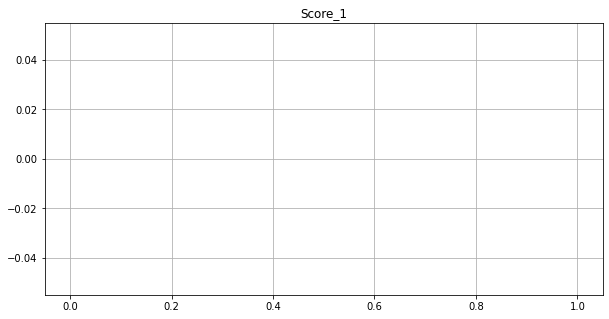

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

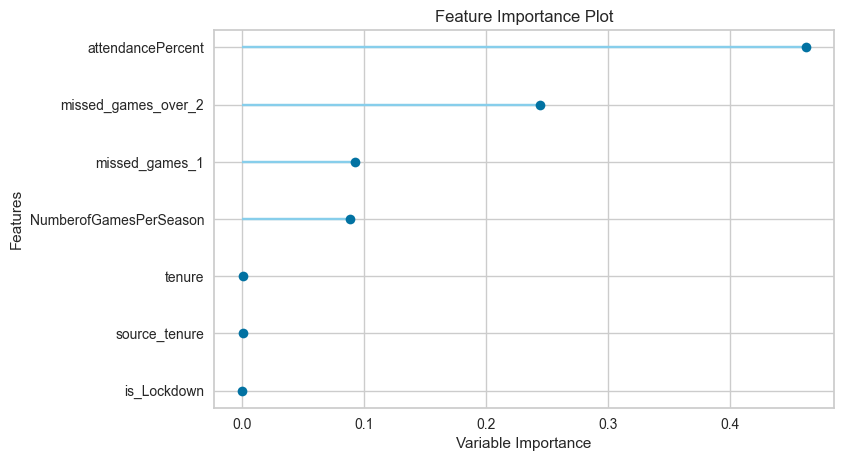

In [14]:
plot_model(best_model, plot='feature')

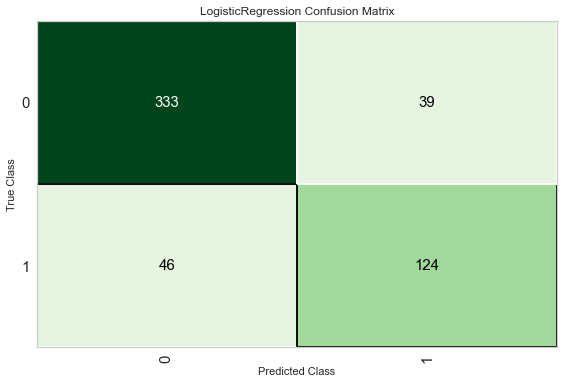

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?